In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

Data import

In [2]:
dataset = pd.read_csv('/kaggle/input/fer2018/fer20131.csv') 
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
dataset['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [4]:
dataset.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
dataset.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [6]:
train_df = dataset[dataset["Usage"] == "Training"]
val_df = dataset[dataset["Usage"] == "PublicTest"]
test_df = dataset[dataset["Usage"] == "PrivateTest"]

In [7]:
emotions = dataset['emotion']

In [8]:
dataset['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

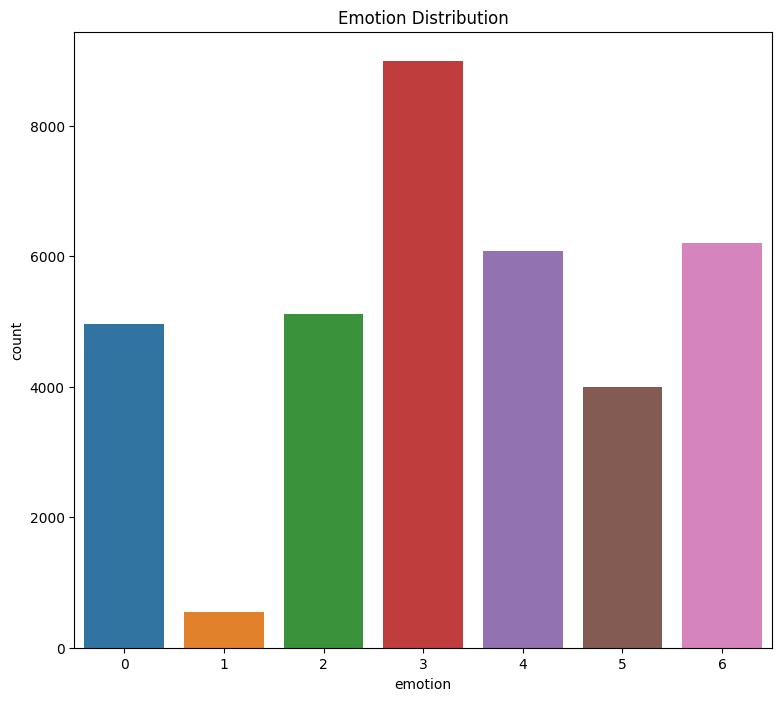

In [9]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution')

In [10]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class FER2018Dataset(Dataset):
    """
    Parse raw data to form a Dataset of (X, y).
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = {
            0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
        }

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['emotion'])
        
        # Ensure 'pixels' is a string before processing
        if isinstance(row["pixels"], str):
            img = np.fromstring(row["pixels"], sep=' ', dtype=np.uint8).reshape(48, 48)
        else:
            raise ValueError(f"Unexpected data type for pixels: {type(row['pixels'])}")
        
        # Convert grayscale to RGB
        img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Shape: (48, 48, 3)
        
        # Convert NumPy array to PIL Image for better transformation compatibility
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(np.array(img), dtype=torch.float).permute(2, 0, 1)  # Convert to (C, H, W)

        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [11]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = FER2018Dataset(train_df, train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

In [12]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=True)

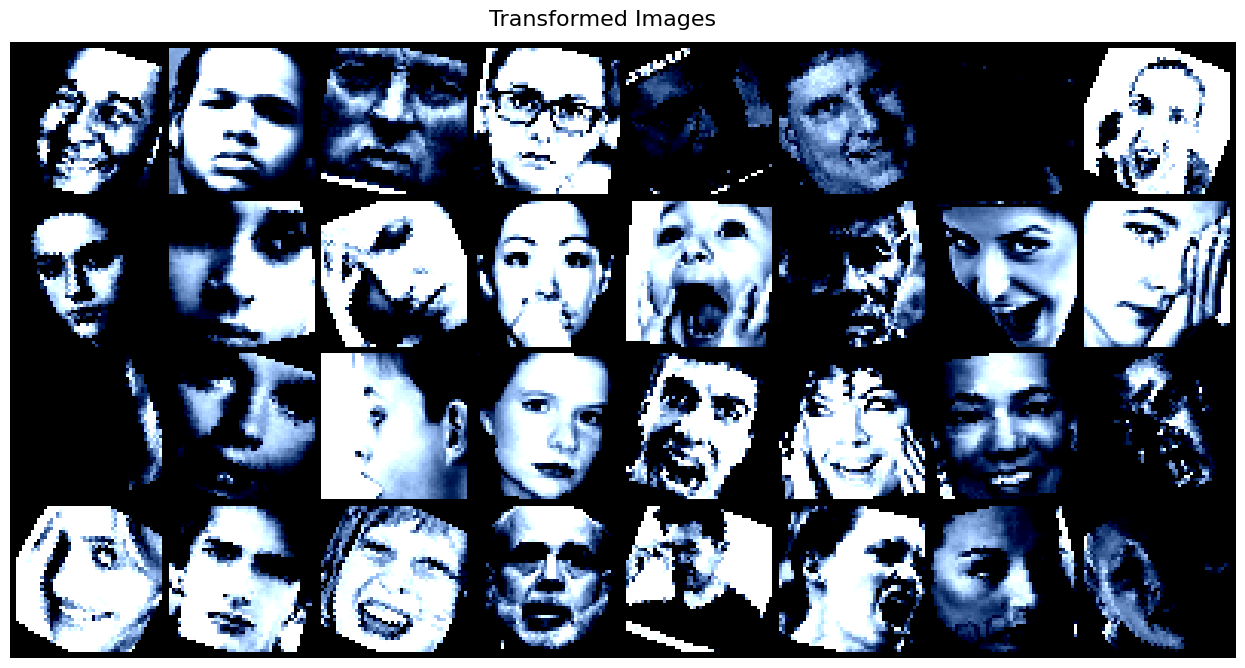

In [13]:
with torch.no_grad():
    data = next(iter(train_dataloader))
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(data["image"].clone().detach(), nrow=8).permute((1, 2, 0))) # move the channel dimension

    _ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet9(nn.Module):
    def __init__(self, num_classes=7):  # FER2018 has 7 classes
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)

        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)

        self.res2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.conv3(x))

        x = x + self.res1(x)  # Residual connection

        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.conv5(x))

        x = x + self.res2(x)  # Residual connection

        x = self.classifier(x)
        return x

# Initialize model
model = ResNet9(num_classes=7)


In [16]:


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary (optional)
print(model)

ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [17]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0
   
    for data in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = data['image'].to("cuda"), data['label'].to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)
        
        loss.backward()
        optimizer.step()
    
    train_loss = train_running_loss / len(dataloader)       
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [18]:
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()
    
    valid_running_loss = 0.0
    vaild_running_acc = 0.0
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)
           
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)
        
    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)
    
    return valid_loss, valid_acc


In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
epochs = 15
lr = 0.0005

loss_function = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [21]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, epochs + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)
    
    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.7811,          Train acc: 0.2637,          Val loss: 1.8055,          Val acc: 0.2775          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 1.5711,          Train acc: 0.3824,          Val loss: 1.5909,          Val acc: 0.3805          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.4030,          Train acc: 0.4625,          Val loss: 1.3240,          Val acc: 0.4868          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 1.3287,          Train acc: 0.4937,          Val loss: 1.3838,          Val acc: 0.4746          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.2667,          Train acc: 0.5163,          Val loss: 1.4866,          Val acc: 0.4614          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 1.2331,          Train acc: 0.5320,          Val loss: 1.1959,          Val acc: 0.5408          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 1.1942,          Train acc: 0.5474,          Val loss: 1.2712,          Val acc: 0.5188          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 1.1744,          Train acc: 0.5539,          Val loss: 1.2458,          Val acc: 0.5280          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 1.1545,          Train acc: 0.5634,          Val loss: 1.1800,          Val acc: 0.5518          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 1.1320,          Train acc: 0.5707,          Val loss: 1.1407,          Val acc: 0.5696          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 1.1199,          Train acc: 0.5787,          Val loss: 1.2590,          Val acc: 0.5214          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 1.1087,          Train acc: 0.5801,          Val loss: 1.1307,          Val acc: 0.5742          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 1.0888,          Train acc: 0.5894,          Val loss: 1.0825,          Val acc: 0.5934          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 1.0801,          Train acc: 0.5940,          Val loss: 1.1183,          Val acc: 0.5790          


Training...:   0%|          | 0/898 [00:00<?, ?it/s]

Validating...:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 1.0677,          Train acc: 0.5981,          Val loss: 1.1814,          Val acc: 0.5590          
DONE TRAINING


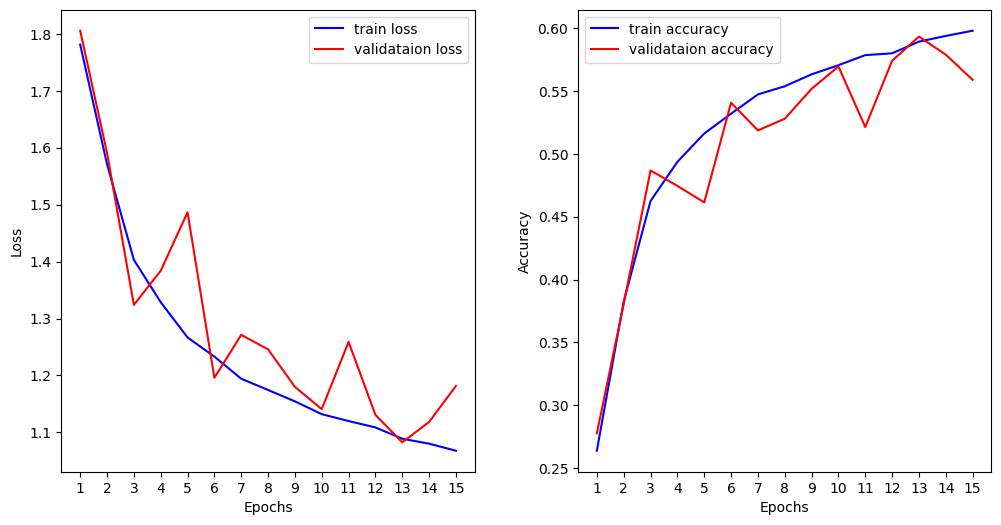

In [22]:
plt.figure(figsize=(12, 6))

# loss plot
plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs), range(1, epochs + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plot
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.xticks(range(epochs), range(1, epochs + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()


In [23]:
def test(model, dataloader):
    model.eval()
    
    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)
           
            outputs = model(images)
            
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

In [24]:
classes = list(test_dataset.classes.values())

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)


Testing...:   0%|          | 0/113 [00:00<?, ?it/s]

In [25]:
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.6762
Accuracy for class: Sad   is 0.2963
Accuracy for class: Happy is 0.8123
Accuracy for class: Neutral is 0.5224
Accuracy for class: Surprise is 0.8173
Accuracy for class: Fear  is 0.3617
Accuracy for class: Disgust is 0.0909
Total accuracy: 0.5809


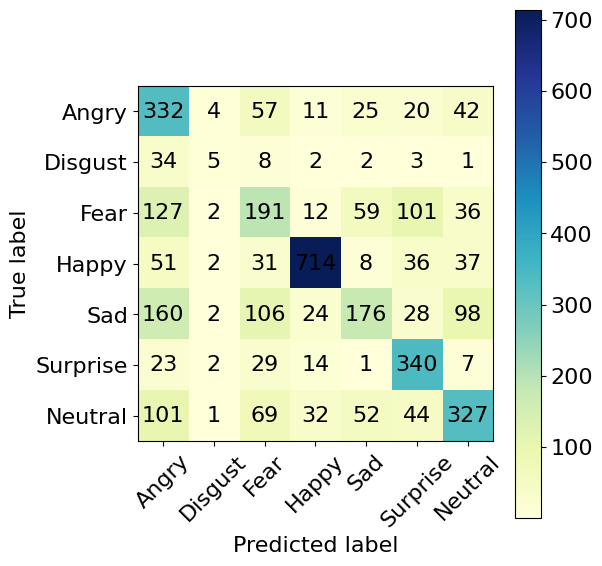

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0, len(classes)):
        for j in range(0, len(classes)):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(all_labels, all_predictions, cmap=plt.cm.YlGnBu)
plt.show()
